# TONG CODE

# Data Loading

## Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore') 

import librosa
from librosa import display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import json

In [134]:
# setting seeds
np.random.seed(0)
torch.manual_seed(0)

## Load Data

In [2]:
# this is all sorts of messy

In [3]:
all_genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
num_songs = 100
sr = 22050
Y_LIMIT = 660000

In [4]:
class DataLoader():
    def __init__(self, seg=5):
        '''
        Initializes the DataLoader.
        
        Forces deteriminism by setting np.seed=1.
        
        self.SEG is the number of fixed-length segments, and the number of random crops to take
        self.SEG_LENGTH is the length of each fixed-length segment
        self.RANDOM_SEG_LENGTH is the length of each random crop
        
        self.train_idxs is a list of 750 training indices
        self.test_idxs is a list of 250 testing indices
        
        self.train_crop_idxs is a list of 750*self.SEG training indices, corresponding to the same indices above
        self.test_crop_idxs  is a list of 750*self.SEG testing indices,  corresponding to the same indices above
        
        eg. train_idxs      = [1, 2, 4, ...]
            train_crop_idxs = [10 ... 19, 20 ... 29, 40 ... 49, ...]
            
        Cropped X's retain the order of the uncropped X's
        i.e. the first 10 self.mfcc_fixed_crop entries correspond to the first self.mfcc entry.
        '''
        np.random.seed(1)
        self.X_mfcc = None
        self.X_mfcc_random_crop = None
        self.X_mfcc_fixed_crop = None
        
        self.X_chroma = None
        self.X_chroma_random_crop = None
        self.X_chroma_fixed_crop = None
        
        self.Y = None
        self.Y_crop = None
        
        self.SEG = seg   # Must evenly divide 30
        self.SEG_LENGTH = int(1290/self.SEG)
        self.RANDOM_SEG_LENGTH = 1200
        self.PAD = 1290 - self.RANDOM_SEG_LENGTH
        self.RANDOM_STARTS = np.random.randint(low=0, high=1290-self.RANDOM_SEG_LENGTH, size=(1000, self.SEG))
        
        self.train_idxs = np.sort(np.random.choice(np.array([i for i in range(1000)]), size=500, replace=False))
        self.val_idxs = np.sort(np.random.choice(np.array([i for i in range(1000) if i not in self.train_idxs]), size=250, replace=False))
        self.test_idxs = np.array([i for i in range(1000) if i not in self.train_idxs and i not in self.val_idxs])

        self.train_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.train_idxs])
        self.val_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.val_idxs])
        self.test_crop_idxs = np.hstack([np.array([i*self.SEG+j for j in range(self.SEG)]) for i in self.test_idxs])

    def save_mfcc(self, genres=all_genres, songs=num_songs):
        '''
        Saves MFCC Coefficients.
        Produces a 1000 x 16770 array.
        '''
        assert(self.X_mfcc is None)
        X_mfcc = None
        for g_idx, g in enumerate(genres):
            for s_idx in range(songs):
                y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.au')
                y = y[:Y_LIMIT]
                mfcc = librosa.feature.mfcc(y, sr=sr, hop_length=512, n_mfcc=13).flatten()
                if X_mfcc is None:
                    X_mfcc = mfcc.reshape(1, mfcc.shape[0])
                else:
                    X_mfcc = np.vstack([X_mfcc, mfcc])
        scaler = StandardScaler()
        self.X_mfcc = scaler.fit_transform(X_mfcc)
        np.savetxt('data/X_mfcc.csv', self.X_mfcc)
    
    def save_mfcc_random_crop(self):
        '''
        Saves self.SEG random crops of MFCC for every original training sample.
        
        Produces a 10000 x 13 x 1200 array, padded with zeros to 10000 x 13 x 1290.
        Reshapes into 10000*16770 for the CSV.
        '''
        assert(self.X_mfcc_random_crop is None and self.X_mfcc is not None)
        X_mfcc_crop = None
        for i, mfcc in enumerate(self.X_mfcc):
            crop = None
            for j in range(self.SEG):
                random_start = self.RANDOM_STARTS[i][j]
                random_seg = np.vstack([mfcc[1290*k+random_start : 1290*k+random_start+self.RANDOM_SEG_LENGTH] for k in range(13)])
                random_seg = np.pad(random_seg, ((0, 0), (0, self.PAD)), 'constant')
                random_seg = random_seg.reshape(1, random_seg.shape[0], random_seg.shape[1])
                if crop is None:
                    crop = random_seg
                else:
                    crop = np.vstack([crop, random_seg])
            if X_mfcc_crop is None:
                X_mfcc_crop = crop
            else:
                X_mfcc_crop = np.vstack([X_mfcc_crop, crop])
        self.X_mfcc_random_crop = X_mfcc_crop
        np.savetxt(f'data/X_mfcc_random_crop_{self.SEG}.csv', X_mfcc_crop.reshape(1000*self.SEG, 13*1290))
    
    def save_mfcc_fixed_crop(self):
        '''
        Saves self.SEG even segments of MFCC for every original training sample.
        
        Produces a 10000 x 13 x 129 array of MFCC coefficients for the segments.
        Reshapes into 10000*1677 for the CSV.
        '''
        assert(self.X_mfcc_fixed_crop is None and self.X_mfcc is not None)
        X_mfcc_crop = None
        for mfcc in self.X_mfcc:
            crop = np.stack([np.vstack([mfcc[1290*j+self.SEG_LENGTH*i : 1290*j+self.SEG_LENGTH*(i+1)] for j in range(13)]) for i in range(self.SEG)], axis=0)
            if X_mfcc_crop is None:
                X_mfcc_crop = crop
            else:
                X_mfcc_crop = np.vstack([X_mfcc_crop, crop])
        self.X_mfcc_fixed_crop = X_mfcc_crop
        np.savetxt(f'data/X_mfcc_fixed_crop_{self.SEG}.csv', X_mfcc_crop.reshape(1000*self.SEG, 13*self.SEG_LENGTH))
    
    def save_chroma(self, genres=all_genres, songs=num_songs):
        '''
        Saves Chromas.
        Produces a 1000 x 15480 array.
        '''
        assert(self.X_chroma is None)
        X_chroma = None
        for g_idx, g in enumerate(genres):
            for s_idx in range(songs):
                y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.au')
                y = y[:Y_LIMIT]
                chroma = librosa.feature.chroma_cqt(y, sr=sr, hop_length=512).flatten()
                if X_chroma is None:
                    X_chroma = chroma.reshape(1, chroma.shape[0])
                else:
                    X_chroma = np.vstack([X_chroma, chroma])
        scaler = StandardScaler()
        self.X_chroma = scaler.fit_transform(X_chroma)
        np.savetxt('data/X_chroma.csv', self.X_chroma)

    def save_chroma_random_crop(self):
        '''
        Saves 10 random crops of Chromas for every original training sample.
        
        Produces a 10000 x 12 x 1200 array, padded with zeros to 10000 x 12 x 1290.
        Reshapes into 10000*15480 for the CSV.
        '''
        assert(self.X_chroma_random_crop is None and self.X_chroma is not None)
        X_chroma_crop = None
        for i, chroma in enumerate(self.X_chroma):
            crop = None
            for j in range(self.SEG):
                random_start = self.RANDOM_STARTS[i][j]
                random_seg = np.vstack([chroma[1290*k+random_start : 1290*k+random_start+self.RANDOM_SEG_LENGTH] for k in range(12)])
                random_seg = np.pad(random_seg, ((0, 0), (0, self.PAD)), 'constant')
                random_seg = random_seg.reshape(1, random_seg.shape[0], random_seg.shape[1])
                if crop is None:
                    crop = random_seg
                else:
                    crop = np.vstack([crop, random_seg])
            if X_chroma_crop is None:
                X_chroma_crop = crop
            else:
                X_chroma_crop = np.vstack([X_chroma_crop, crop])
        self.X_chroma_random_crop = X_chroma_crop
        np.savetxt(f'data/X_chroma_random_crop_{self.SEG}.csv', X_chroma_crop.reshape(1000*self.SEG, 12*1290))
        
    def save_chroma_fixed_crop(self):
        '''
        Saves 10 even segments of Chromas for every original training sample.
        
        Produces a 10000 x 12 x 129 array of MFCC coefficients for the segments.
        Reshapes into 10000*1548 for the CSV.
        '''
        assert(self.X_chroma_fixed_crop is None and self.X_chroma is not None)
        X_chroma_crop = None
        for chroma in self.X_chroma:
            crop = np.stack([np.vstack([chroma[1290*j+self.SEG_LENGTH*i : 1290*j+self.SEG_LENGTH*(i+1)] for j in range(12)]) for i in range(self.SEG)], axis=0)
            if X_chroma_crop is None:
                X_chroma_crop = crop
            else:
                X_chroma_crop = np.vstack([X_chroma_crop, crop])
        self.X_chroma_fixed_crop = X_chroma_crop
        np.savetxt(f'data/X_chroma_fixed_crop_{self.SEG}.csv', X_chroma_crop.reshape(1000*self.SEG, 12*self.SEG_LENGTH))
    
    '''
    If X_mfcc has been saved, but we aborted before saving X_mfcc_random_crop (or X_mfcc_fixed_crop), 
    we can call load_mfcc with tensor=False to load the MFCC in 2D and then call dl.save_random_crop().
    Note that all load functions reshape into tensors by default.
    '''  
    
    def load_mfcc(self, tensor=True):
        self.X_mfcc = np.loadtxt('data/X_mfcc.csv')
        if tensor:
            self.X_mfcc = self.X_mfcc.reshape(1000, 13, 1290)
    
    def load_mfcc_random_crop(self):
        self.X_mfcc_random_crop = np.loadtxt(f'data/X_mfcc_random_crop_{self.SEG}.csv').reshape(1000*self.SEG, 13, 1290)
        
    def load_mfcc_fixed_crop(self):
        self.X_mfcc_fixed_crop = np.loadtxt(f'data/X_mfcc_fixed_crop_{self.SEG}.csv').reshape(1000*self.SEG, 13, self.SEG_LENGTH)
        
    def load_chroma(self, tensor=True):
        self.X_chroma = np.loadtxt('data/X_chroma.csv')
        if tensor:
            self.X_chroma = self.X_chroma.reshape(1000, 12, 1290)
    
    def load_chroma_random_crop(self):
        self.X_chroma_random_crop = np.loadtxt(f'data/X_chroma_random_crop_{self.SEG}.csv').reshape(1000*self.SEG, 12, 1290)
        
    def load_chroma_fixed_crop(self):
        self.X_chroma_fixed_crop = np.loadtxt(f'data/X_chroma_fixed_crop_{self.SEG}.csv').reshape(1000*self.SEG, 12, self.SEG_LENGTH)
    
    def load_Y(self):
        self.Y = np.array([int(i/100) for i in range(1000)]).ravel()
        
    def load_Y_crop(self):
        self.Y_crop = np.array([int(i/(100 * self.SEG)) for i in range(1000 * self.SEG)]).ravel()
        
    def train_test_val_split(self, data, is_cropped):
        '''
        Splits an X_data into train, validation, and test sets.
        
        is_cropped=True for splitting random or fixed crops, iscropped=False for splitting original mfcc/chroma
        
        Train, val, and test indices are consistent every time train_test_split is called.
        
        Furthermore, cropped train and test indices are returned so that batches of size self.SEG are together, 
        with each batch corresponding to a single non-cropped index.
        '''
        if is_cropped:
            return np.take(data, self.train_crop_idxs, 0), np.take(data, self.val_crop_idxs, 0), np.take(data, self.test_crop_idxs, 0)
        else:
            return np.take(data, self.train_idxs, 0), np.take(data, self.val_idxs, 0), np.take(data, self.test_idxs, 0)

In [236]:
# %%time
# # # Saves features to data/...  (run once!!)
# dl_1 = DataLoader(1)
# dl_1.load_mfcc(tensor = False)
# dl_1.save_mfcc_fixed_crop()
# dl_1.save_mfcc_random_crop()
# dl_1.load_chroma(tensor = False)
# dl_1.save_chroma_fixed_crop()
# dl_1.save_chroma_random_crop()

# dl_2 = DataLoader(2)
# dl_2.load_mfcc(tensor = False)
# dl_2.save_mfcc_fixed_crop()
# dl_2.save_mfcc_random_crop()
# dl_2.load_chroma(tensor = False)
# dl_2.save_chroma_fixed_crop()
# dl_2.save_chroma_random_crop()

# dl_5 = DataLoader(5)
# dl_5.load_mfcc(tensor = False)
# dl_5.save_mfcc_fixed_crop()
# dl_5.save_mfcc_random_crop()
# dl_5.load_chroma(tensor = False)
# dl_5.save_chroma_fixed_crop()
# dl_5.save_chroma_random_crop()

# dl_30 = DataLoader(30)
# dl_30.load_mfcc(tensor = False)
# dl_30.save_mfcc_fixed_crop()
# # dl_30.save_mfcc_random_crop()
# dl_30.load_chroma(tensor = False)
# dl_30.save_chroma_fixed_crop()
# # dl_30.save_chroma_random_crop()

In [237]:
%%time
# # Load from CSVs in data/...
dl_1 = DataLoader(1)
dl_1.load_mfcc()
dl_1.load_mfcc_fixed_crop()
dl_1.load_mfcc_random_crop()
dl_1.load_chroma()
dl_1.load_chroma_fixed_crop()
dl_1.load_chroma_random_crop()
dl_1.load_Y()
dl_1.load_Y_crop()

dl_2 = DataLoader(2)
dl_2.load_mfcc()
dl_2.load_mfcc_fixed_crop()
dl_2.load_mfcc_random_crop()
dl_2.load_chroma()
dl_2.load_chroma_fixed_crop()
dl_2.load_chroma_random_crop()
dl_2.load_Y()
dl_2.load_Y_crop()

dl_5 = DataLoader(5)
dl_5.load_mfcc()
dl_5.load_mfcc_fixed_crop()
dl_5.load_mfcc_random_crop()
dl_5.load_chroma()
dl_5.load_chroma_fixed_crop()
dl_5.load_chroma_random_crop()
dl_5.load_Y()
dl_5.load_Y_crop()

dl_30 = DataLoader(30)
dl_30.load_mfcc()
dl_30.load_mfcc_fixed_crop()
# dl_30.load_mfcc_random_crop()
dl_30.load_chroma()
dl_30.load_chroma_fixed_crop()
# dl_30.load_chroma_random_crop()
dl_30.load_Y()
dl_30.load_Y_crop()

CPU times: user 8min 33s, sys: 57.3 s, total: 9min 30s
Wall time: 9min 44s


In [238]:
dls = [dl_1, dl_2, dl_5, dl_30]
dls_trunc = [dl_1, dl_2, dl_5]

for dl in dls_trunc:
    print(dl.X_mfcc.shape, dl.X_mfcc_random_crop.shape, dl.X_mfcc_fixed_crop.shape, \
          dl.X_chroma.shape, dl.X_chroma_random_crop.shape, dl.X_chroma_fixed_crop.shape)

print(dl_30.X_mfcc.shape, dl_30.X_mfcc_fixed_crop.shape, dl_30.X_chroma.shape, dl_30.X_chroma_fixed_crop.shape)

(1000, 13, 1290) (1000, 13, 1290) (1000, 13, 1290) (1000, 12, 1290) (1000, 12, 1290) (1000, 12, 1290)
(1000, 13, 1290) (2000, 13, 1290) (2000, 13, 645) (1000, 12, 1290) (2000, 12, 1290) (2000, 12, 645)
(1000, 13, 1290) (5000, 13, 1290) (5000, 13, 258) (1000, 12, 1290) (5000, 12, 1290) (5000, 12, 258)
(1000, 13, 1290) (30000, 13, 43) (1000, 12, 1290) (30000, 12, 43)


## Training and Test sets for each part

In [8]:
# Train on X_train (750),
# Test on X_test (250)
print('Train, validate, and test the vanilla model\n')

Xm_train, Xm_val, Xm_test = dl.train_test_val_split(dl.X_mfcc, is_cropped=False)
Xc_train, Xc_val, Xc_test = dl.train_test_val_split(dl.X_chroma, is_cropped=False)

X_train = np.concatenate([Xm_train, Xc_train], axis=1)
X_val = np.concatenate([Xm_val, Xc_val], axis=1)
X_test = np.concatenate([Xm_test, Xc_test], axis=1)

Y_train, Y_val, Y_test = dl.train_test_val_split(dl.Y, is_cropped=False)

print(f'Train size:    {X_train.shape}', f'     Train labels size: {Y_train.shape}')
print(f'Val size:      {X_val.shape}', f'     Val labels size:   {Y_val.shape}')
print(f'Test size:     {X_test.shape}', f'     Test labels size:  {Y_test.shape}')

Train, validate, and test the vanilla model

Train size:    (500, 25, 1290)      Train labels size: (500,)
Val size:      (250, 25, 1290)      Val labels size:   (250,)
Test size:     (250, 25, 1290)      Test labels size:  (250,)


In [9]:
# Train on X_mfcc_fixed_crop_train (7500),
# Test on X_mfcc_fixed_crop_test (2500),
# Aggregate into predictions on X_mfcc_test (250)
print('Train on segments, validate and test by accumulating votes of segments\n')

Xmf_train, Xmf_val, Xmf_test = \
    dl.train_test_val_split(dl.X_mfcc_fixed_crop, is_cropped=True)
Xcf_train, Xcf_val, Xcf_test = \
    dl.train_test_val_split(dl.X_chroma_fixed_crop, is_cropped=True)

Xf_train = np.concatenate([Xmf_train, Xcf_train], axis=1)
Xf_val = np.concatenate([Xmf_val, Xcf_val], axis=1)
Xf_test = np.concatenate([Xmf_test, Xcf_test], axis=1)

Y_crop_train, _, _ = dl.train_test_val_split(dl.Y_crop, is_cropped=True)

print(f'Train size:  {Xf_train.shape}', f'     Train labels size: {Y_crop_train.shape}')
print(f'Val size:    {Xf_val.shape}', f'     Val labels size:   {Y_val.shape}')
print(f'Test size:   {Xf_test.shape}', f'     Test labels size:  {Y_test.shape}')

Train on segments, validate and test by accumulating votes of segments

Train size:  (2500, 25, 258)      Train labels size: (2500,)
Val size:    (1250, 25, 258)      Val labels size:   (250,)
Test size:   (1250, 25, 258)      Test labels size:  (250,)


In [10]:
# Train on X_mfcc_random_crop_train (7500),
# Test on X_mfcc_test (250)
print('Train on padded random crops, validate and test on uncropped test\n')

Xmr_train, _, _ = dl.train_test_val_split(dl.X_mfcc_random_crop, is_cropped=True)
Xcr_train, _, _ = dl.train_test_val_split(dl.X_chroma_random_crop, is_cropped=True)

Xr_train = np.concatenate([Xmr_train, Xcr_train], axis=1)

Y_crop_train, _, _ = dl.train_test_val_split(dl.Y_crop, is_cropped=True)

print(f'Train size:   {Xr_train.shape}', f'    Train labels size: {Y_crop_train.shape}')
print(f'Val size:     {X_val.shape}', f'     Val labels size:   {Y_val.shape}')
print(f'Test size:    {X_test.shape}', f'     Test labels size:  {Y_test.shape}')

Train on padded random crops, validate and test on uncropped test

Train size:   (2500, 25, 1290)     Train labels size: (2500,)
Val size:     (250, 25, 1290)      Val labels size:   (250,)
Test size:    (250, 25, 1290)      Test labels size:  (250,)


## PyTorch DataLoader

In [11]:
# making torch style dataset and dataloader

import torch
from torch.utils import data

class GenreDataset(data.Dataset):

    def __init__(self, X, Y = None):
        self.X = torch.from_numpy(X).unsqueeze(1)
        if type(Y) != type(None):
            self.Y = torch.from_numpy(Y)
        else:
            self.Y = None
            
    def __len__(self):
        if type(self.Y) != type(None):
            assert(self.X.size()[0] == self.Y.size()[0])
        return self.X.size()[0]

    def __getitem__(self, index):
        data = self.X[index]
        if type(self.Y) != type(None):
            label = self.Y[index]
        else:
            label = 0
        return (data, label)

# Models

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import math
from torchsummary import summary

## CNN + RNN, FC + RNN

In [125]:
class CNN(nn.Module):
    def __init__(self, params):
        super(CNN, self).__init__()
        
        num_features = params['audio_in_features']
        num_filters_1 = params['cnn_filters_1']
        ker_1 = params['cnn_kernel_1']
        out_features = params['rnn_in_size']
        
        out_size = num_features - ker_1[0] + 1
        
        self.conv1 = nn.Conv2d(1, num_filters_1, ker_1)
        self.fc = nn.Linear(num_filters_1*out_size, out_features)
        
    def forward(self, x):
        # x.size() = N x 1 x 
        
        out = self.conv1(x)
        # out.size() = N x out_channels x out_size x time
        out = F.relu(out)
        # out.size() = N x out_channels x out_size x time
        
        out = out.permute(0,3,1,2)
        # out.size() = N x time x out_channels x out_size
        out = out.view(out.size()[0], out.size()[1], -1)
        # out.size() = N x time x out_channels*out_size
        
        out = self.fc(out)
        # out.size() = N x time x out_features
        out = F.relu(out)
        # out.size() = N x time x out_features
        
        return out

class FC(nn.Module):
    # currently no batchnorm
    
    def __init__(self, params):
        super(FC, self).__init__()
        
        self.deep = params['deep']
        
        fc_1_in = params['audio_in_features']
        fc_1_out = params['fc_1_out']
        fc_2_out = params['fc_2_out']
        if self.deep:
            fc_3_out = params['fc_3_out']
            fc_4_out = params['fc_4_out']
            fc_5_out = params['rnn_in_size']
        else:
            fc_3_out = params['rnn_in_size']
            
        
        self.fc_1 = nn.Linear(fc_1_in, fc_1_out)
        self.bnorm_1 = nn.BatchNorm1d(fc_1_out)
        self.fc_2 = nn.Linear(fc_1_out, fc_2_out)
        self.bnorm_2 = nn.BatchNorm1d(fc_2_out)
        self.fc_3 = nn.Linear(fc_2_out, fc_3_out)
        if self.deep:
            self.fc_4 = nn.Linear(fc_3_out, fc_4_out)
            self.fc_5 = nn.Linear(fc_4_out, fc_5_out)
        
    def forward(self, x):
        out = x.permute(0, 3, 1, 2)
        # out.size() = N x time x 1 x fc_1_in
        
        out = out.view(out.size()[0], out.size()[1], -1)
        # out.size() = N x time x out_size
        
        out = self.fc_1(out)
        # out.size() = N x time x fc_1_out
        out = out.permute(0,2,1)
        # out.size() = N x fc_1_out x time
        if self.deep:
            out = self.bnorm_1(out)
            # out.size() = N x fc_1_out x time
        out = out.permute(0,2,1)
        # out.size() = N x time x fc_1_out
        out = F.relu(out)
        # out.size() = N x time x fc_1_out
        
        out = self.fc_2(out)
        # out.size() = N x time x fc_1_out
        out = out.permute(0,2,1)
        # out.size() = N x fc_2_out x time
        # out = self.bnorm_2(out)
        # out.size() = N x fc_2_out x time
        out = out.permute(0,2,1)
        # out.size() = N x time x fc_2_out
        out = F.relu(out)
        # out.size() = N x time x fc_2_out
        
        out = self.fc_3(out)
        # out.size() = N x time x fc_3_out
        out = F.relu(out)
        # out.size() = N x time x fc_3_out
        
        if self.deep:
            out = self.fc_4(out)
            # out.size() = N x time x fc_4_out
            out = F.relu(out)
            # out.size() = N x time x fc_4_out

            out = self.fc_5(out)
            # out.size() = N x time x fc_5_out
            out = F.relu(out)
            # out.size() = N x time x fc_5_out

        return out
    
class RNN(nn.Module):
    def __init__(self, params):
        super(RNN, self).__init__()
        
        in_size = params['rnn_in_size']
        hid_size = params['rnn_hid_size']
        dropout = params['rnn_dropout']
        
        self.lstm = nn.LSTM(in_size, hid_size, batch_first=True, dropout = dropout)
    
    def forward(self, x):
        out, hidden = self.lstm(x)
        # out.size() = N x time x hid_size
        return out


In [114]:
# trying new architecture ideas:

class CNN_RNN(nn.Module):
    def __init__(self, params):
        super(CNN_RNN, self).__init__()
        
        out_size = params['rnn_hid_size']
        
        self.CNN = CNN(params)
        self.RNN = RNN(params)
        
        self.fc = nn.Linear(out_size, 10)
        
    def forward(self, x):
        out = self.CNN(x)
        # out.size() = N x time x rnn_in_size
        
        out = self.RNN(out)
        # out.size() = N x time x rnn_hid_size
        
        out = out[:,-1,:].squeeze()
        # out.size() = N x rnn_hid_size
        
        out = self.fc(out)
        # out.size() = N x 10
        
        return out
    
class FC_RNN(nn.Module):
    def __init__(self, params):
        super(FC_RNN, self).__init__()
        
        out_size = params['rnn_hid_size']
        
        self.FC = FC(params)
        self.RNN = RNN(params)
        
        self.fc = nn.Linear(out_size, 10)
        
    def forward(self, x):
        out = self.FC(x)
        # out.size() = N x time x fc_3_out
        
        out = self.RNN(out)
        # out.size() = N x time x out_features
        
        out = out[:,-1,:].squeeze()
        # out.size() = N x out_features
        
        out = self.fc(out)
        # out.size() = N x 10
        
        return out

# Training and Testing

In [206]:
# defining training and testing functions

def train_single_epoch(net, criterion, optimizer, trainloader, device, silence = False):
    # assumes net.train() called
    # assumes device is correct

    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)

        _ , predicted = torch.max(outputs.data, 1)

        total += labels.size(0)            

        correct += (predicted == labels).sum().item()            
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()            
        running_loss += loss.item()
    
    acc = (100 * correct / total)
    avg_loss = running_loss / total
    
    if not silence:
        print("Loss: " + str(running_loss / 750.0) + ' Accuracy: ' + str(acc) + '%')
    return avg_loss, acc

def test(net, criterion, testloader, device, silence = False):
    # assumes net.eval() called
    # assumes device is correct
    
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
    acc = 100*correct/total
    avg_loss = running_loss / total
    
    if not silence:
        print('Test accuracy of the network: ' + str(acc) + '%')

    return avg_loss, acc

In [223]:
# mixup stuff

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_single_epoch_mixup(net, criterion, optimizer, trainloader, device, silence = False):
    # assumes net.train() called
    # assumes device is correct

    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device)

        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
        # inputs, targets_a, targets_b = map(Variable, (inputs, targets_a, targets_b))
        
        optimizer.zero_grad()
        outputs = net(inputs)

        _ , predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float().item() + \
                    (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float().item())
        
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        loss.backward()
        optimizer.step()            
        running_loss += loss.item()
    
    acc = (100 * correct / total)
    avg_loss = running_loss / total
    
    if not silence:
        print("Loss: " + str(running_loss / 750.0) + ' Accuracy: ' + str(acc) + '%')
    return avg_loss, acc

In [212]:
def train(epochs, net, criterion, optimizer, trainloader, testloader = None, silence = False, mixup = False):
    # inlude testloader if you want to see progression of train vs testing losses as epochs increase
    # in case of prediction then we use train without testloader; the model then predicts upon stuff
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    for epoch in range(epochs):
        if not silence:
            print("Epoch " + str(epoch+1))
        
        net.train()
        if mixup:
            train_loss, train_acc = train_single_epoch_mixup(net, criterion, optimizer, trainloader, device)
        else:
            train_loss, train_acc = train_single_epoch(net, criterion, optimizer, trainloader, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        if testloader != None:
            net.eval()
            test_loss, test_acc = test(net, criterion, testloader, device)
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            
    return train_losses, train_accs, test_losses, test_accs

# Evaluating Model

In [16]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape)

(500, 25, 1290) (250, 25, 1290) (250, 25, 1290) (500,)


In [ ]:
# THESE ARE THE FINAL PARAMETERS

CNN_RNN_PARAMS = {
    'audio_in_features' : 25, # static
    'cnn_filters_1' : 32, # 32 better than 16 and 48
    'cnn_kernel_1' : (16, 1), # 15 better than 10 and 20
    'rnn_in_size' : 24,
    'rnn_hid_size' : 48,
    'rnn_dropout' : 0.5, # seems to do fairly well
    'epochs' : 75, # probably won't change
    'lr' : 0.01,
    'weight_decay': 0.01,
    
    'silence' : False
}

FC_RNN_PARAMS_2 = {
    'audio_in_features' : 25, # static
    'fc_1_out' : 320, # new
    'fc_2_out' : 160, # new
    'fc_3_out' : 80, # new, used to be fc_3_out = rnn_in_size = 24
    'fc_4_out' : 40, # new
    'rnn_in_size' : 24, # probably okay but will investigate
    'rnn_hid_size' : 48, # probably okay 
    'rnn_dropout' : 0.5, # okay
    'epochs' : 75, # okay
    'lr' : 0.001, # seems like it works well enough
    'weight_decay': 0, # seems to not really have an affect
    'deep' : True,
    
    'silence' : False
    # using 1 bnorm layer
}

In [17]:
# attempt at regularization

class WeightClipper():

    def __init__(self):
        pass

    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-1,1)

In [177]:
def plot_learning_curve(train_losses, train_accs, test_losses, test_accs):
    tested = (len(test_losses) > 0)
    
    
    plt.figure(1)
    plt.plot(list(range(1, len(train_losses)+1)), train_losses, '-b', label='Training Loss')
    if tested:    
        plt.plot(list(range(1, len(train_losses)+1)), test_losses, '-r', label='Testing Loss')
        plt.title('Training and Testing Loss')
    else:
        plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    
    plt.figure(2)
    plt.plot(list(range(1, len(train_losses)+1)), train_accs, '-b', label='Training Accuracy')
    if tested:
        plt.plot(list(range(1, len(train_losses)+1)), test_accs, '-r', label='Testing Accuracy')
        plt.title('Training and Testing Accuracy')
    else:
        plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    
    plt.show()

def find_best_stopping_point(test_losses, test_accs):
    
    best_loss = min(test_losses)
    best_loss_index = test_losses.index(best_loss)
    
    best_acc = max(test_accs)
    best_acc_index = test_accs.index(best_acc)
    
    print("Best loss of " + str(best_loss) +" after " + str(best_loss_index+1) + " epochs of training")
    print("Best accuracy of " + str(best_acc) +" after " + str(best_acc_index+1) + " epochs of training")
    
    return (best_loss_index+1, best_acc_index+1) 
        

In [213]:
def nn_test_architecture(net_class, params, mixup, x_train, y_train, x_test, y_test):
    # net_class = CNN_RNN or FC_RNN
    
    # handling data; creating torch datasets and torch dataloaders
    
    trainset = GenreDataset(x_train, y_train)
    testset = GenreDataset(x_test, y_test)
    
    trainloader = data.DataLoader(trainset, batch_size = 64, shuffle = True)
    testloader = data.DataLoader(testset, batch_size = 64, shuffle = False)
    
    # constructing net and surrounding items
    
    params['audio_in_features'] = x_train.shape[1]
    
    net = net_class(params)
    net.float()
    clipper = WeightClipper()
    net.apply(clipper)
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters(), lr=params['lr'], weight_decay = params['weight_decay'])
    num_epochs = params['epochs']
    silence = params['silence']

    train_losses, train_accs, test_losses, test_accs = train(num_epochs, net, crit, opt, trainloader, testloader, \
                                                             silence = silence, mixup = mixup)
    
    # displaying learning curve
    
    if not silence:
        plot_learning_curve(train_losses, train_accs, test_losses, test_accs)
    return test_losses, test_accs

In [226]:
mixup_val_losses, mixup_val_accs = nn_test_architecture(FC_RNN, FC_RNN_PARAMS_1, True, X_train, Y_train, X_val, Y_val)
print("")
print("Mixup Validation Final Loss: " + str(mixup_val_losses[-1]))

Epoch 1
Loss: 0.024556570688883464 Accuracy: 12.807963007027814%
Test accuracy of the network: 18.4%
Epoch 2


KeyboardInterrupt: 

Epoch 1
Loss: 0.024530786196390788 Accuracy: 11.2%
Test accuracy of the network: 11.6%
Epoch 2
Loss: 0.02430980110168457 Accuracy: 13.225682187609184%
Test accuracy of the network: 22.4%
Epoch 3
Loss: 0.023650691986083983 Accuracy: 22.345856560158936%
Test accuracy of the network: 22.8%
Epoch 4
Loss: 0.022665285746256512 Accuracy: 27.009161274284185%
Test accuracy of the network: 27.2%
Epoch 5
Loss: 0.0226143217086792 Accuracy: 23.936322511174453%
Test accuracy of the network: 32.8%
Epoch 6
Loss: 0.02158471139272054 Accuracy: 26.605382155810375%
Test accuracy of the network: 30.8%
Epoch 7
Loss: 0.021274851004282634 Accuracy: 29.778750256391756%
Test accuracy of the network: 36.4%
Epoch 8
Loss: 0.020663827101389566 Accuracy: 32.87336779437848%
Test accuracy of the network: 36.4%
Epoch 9
Loss: 0.0194682404200236 Accuracy: 36.90110831539628%
Test accuracy of the network: 37.2%
Epoch 10
Loss: 0.02050904607772827 Accuracy: 31.718337334618546%
Test accuracy of the network: 34.8%
Epoch 11
Los

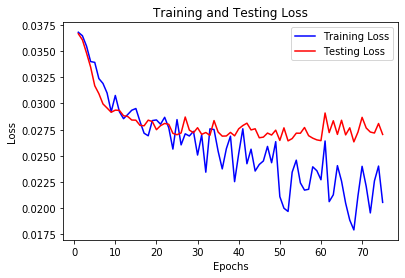

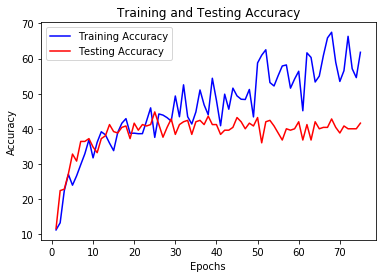

In [224]:
mixup_test_losses, mixup_test_accs = nn_test_architecture(FC_RNN, FC_RNN_PARAMS_1, True, X_train, Y_train, X_test, Y_test)
print("")
print("Mixup Test Final Loss: " + str(mixup_test_losses[-1]))

In [227]:
def predictions(net, loader):
    # return numpy array of model's predictions
    
    separate_predictions = []
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    net.eval()
    
    with torch.no_grad():
        for data in loader:
            
            inputs, _ = data
            inputs = inputs.to(device).float()

            outputs = net(inputs)
            _ , predicted = torch.max(outputs.data, 1)
            separate_predictions.append(predicted.numpy())
    
    predictions = np.concatenate(separate_predictions)
    return predictions

In [228]:
def nn_evaluate(net_class, params, x_train, y_train, x_val, x_test):
    # net_class = CNN_RNN or FC_RNN
    
    # handling data; creating torch datasets and torch dataloaders
    
    trainset = GenreDataset(x_train, y_train)
    valset = GenreDataset(x_val)
    testset = GenreDataset(x_test)
    
    trainloader = data.DataLoader(trainset, batch_size = 64, shuffle = True)
    valloader = data.DataLoader(valset, batch_size = 64, shuffle = False)
    testloader = data.DataLoader(testset, batch_size = 64, shuffle = False)
    
    # constructing net and surrounding items
    
    params['audio_in_features'] = x_train.shape[1]
    
    net = net_class(params)
    net.float()
    clipper = WeightClipper()
    net.apply(clipper)
    crit = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters(), lr=params['lr'], weight_decay = params['weight_decay'])
    num_epochs = params['epochs']
    silence = params['silence']

    train_losses, train_accs, test_losses, test_accs = train(num_epochs, net, crit, opt, trainloader, silence = silence)
    
    # displaying learning curve
    
    if not silence:
        plot_learning_curve(train_losses, train_accs, test_losses, test_accs)
    
    # generating outputs
    
    val_predictions = predictions(net, valloader)
    test_predictions = predictions(net, testloader)

    return val_predictions, test_predictions, net # in case we want to save the net

In [248]:
def nn_analysis(x_train, y_train, x_val, x_test, architecture, names = None):
    
    assert(architecture in ['cnn_rnn', 'shallow_fc_rnn', 'deep_fc_rnn'])
    
    if names == None:
        names = {
            'val_predictions' : 'val_predictions',
            'test_predictions' : 'test_predictions',
            'model' : 'model',
        }
    
    if architecture == 'cnn_rnn':
        val_predictions, test_predictions, model = nn_evaluate(CNN_RNN, CNN_RNN_PARAMS, x_train, y_train, x_val, x_test)
    elif architecture == 'shallow_fc_rnn':
        val_predictions, test_predictions, model = nn_evaluate(FC_RNN, FC_RNN_PARAMS_1, x_train, y_train, x_val, x_test)
    elif architecture == 'deep_fc_rnn':
        val_predictions, test_predictions, model = nn_evaluate(FC_RNN, FC_RNN_PARAMS_2, x_train, y_train, x_val, x_test)
    else:
        raise ValueError("Architecture incorrect and also this is impossible.")
    
    # saving outputs
    
    np.save('nn/' + names['val_predictions'] + '.npy', val_predictions)
    np.save('nn/' + names['test_predictions'] + '.npy', test_predictions)
        
    # saving models
    
    torch.save(model.state_dict(), 'nn/' + names['model'] + '.pth')
        
    return names

In [230]:
def load_nn_analysis(architecture, names):
    
    val_predictions = np.load('nn/' + names['val_predictions'] + '.npy')
    test_predictions = np.load('nn/' + names['test_predictions'] + '.npy')
    
    if architecture == 'cnn_rnn':
        model = CNN_RNN(CNN_RNN_PARAMS)
    elif architecture == 'shallow_fc_rnn':
        shallow_fc_rnn_model = FC_RNN(FC_RNN_PARAMS_1)
    elif architecture == 'deep_fc_rnn':
        deep_fc_rnn_model = FC_RNN(FC_RNN_PARAMS_2)
    else:
        raise ValueError("Architecture incorrect and also this is impossible.")

    model.load_state_dict(torch.load('nn/' + names['model'] + '.pth'))

    return val_predictions, test_predictions, model

In [231]:
def make_vanilla(dl):
    Xm_train, Xm_val, Xm_test = dl.train_test_val_split(dl.X_mfcc, is_cropped=False)
    Xc_train, Xc_val, Xc_test = dl.train_test_val_split(dl.X_chroma, is_cropped=False)

    X_train = np.concatenate([Xm_train, Xc_train], axis=1)
    X_val = np.concatenate([Xm_val, Xc_val], axis=1)
    X_test = np.concatenate([Xm_test, Xc_test], axis=1)

    Y_train, Y_val, Y_test = dl.train_test_val_split(dl.Y, is_cropped=False)
    return X_train, Y_train, X_val, X_test

def make_fixed_crop(dl):
    Xmf_train, Xmf_val, Xmf_test = dl.train_test_val_split(dl.X_mfcc_fixed_crop, is_cropped=True)
    Xcf_train, Xcf_val, Xcf_test = dl.train_test_val_split(dl.X_chroma_fixed_crop, is_cropped=True)

    Xf_train = np.concatenate([Xmf_train, Xcf_train], axis=1)
    Xf_val = np.concatenate([Xmf_val, Xcf_val], axis=1)
    Xf_test = np.concatenate([Xmf_test, Xcf_test], axis=1)

    Y_crop_train, _, _ = dl.train_test_val_split(dl.Y_crop, is_cropped=True)
    return Xf_train, Y_crop_train, Xf_val, Xf_test
    
def make_random_crop(dl):
    Xmr_train, _, _ = dl.train_test_val_split(dl.X_mfcc_random_crop, is_cropped=True)
    Xcr_train, _, _ = dl.train_test_val_split(dl.X_chroma_random_crop, is_cropped=True)

    Xr_train = np.concatenate([Xmr_train, Xcr_train], axis=1)

    Y_crop_train, _, _ = dl.train_test_val_split(dl.Y_crop, is_cropped=True)
    return Xr_train, Y_crop_train

In [242]:
def analyze_data_augmentation(dl, seg_number, random_crop = True):
    X_train, Y_train, X_val, X_test = make_vanilla(dl)
    Xf_train, Y_crop_train, Xf_val, Xf_test = make_fixed_crop(dl)
    if random_crop:
        Xr_train, Y_crop_train = make_random_crop(dl)
    
    names_vanilla = {
        'val_predictions' : 'val_predictions_vanilla_' + str(seg_number),
        'test_predictions' : 'test_predictions_vanilla_' + str(seg_number),
        'model' : 'model_vanilla_' + str(seg_number)
    }

    names_fixed_crop = {
        'val_predictions' : 'val_predictions_fixed_crop_' + str(seg_number),
        'test_predictions' : 'test_predictions_fixed_crop_' + str(seg_number),
        'model' : 'model_fixed_crop_' + str(seg_number)
    }

    names_random_crop = {
        'val_predictions' : 'val_predictions_random_crop_' + str(seg_number),
        'test_predictions' : 'test_predictions_random_crop_' + str(seg_number),
        'model' : 'model_random_crop_' + str(seg_number)
    }

    nn_analysis(X_train, Y_train, X_val, X_test, 'shallow_fc_rnn', names_vanilla)
    nn_analysis(Xf_train, Y_crop_train, Xf_val, Xf_test, 'shallow_fc_rnn', names_fixed_crop)
    if random_crop:
        nn_analysis(Xr_train, Y_crop_train, X_val, X_test, 'shallow_fc_rnn', names_random_crop)

In [246]:
def analyze_all_data_augmentations(dls):
    for index, seg_number in enumerate([1,2,5,30]):
        random_crop = not (seg_number == 30)
        dl = dls[index]
        analyze_data_augmentation(dl, seg_number, random_crop = random_crop)

Epoch 1
Loss: 0.024644586245218914 Accuracy: 10.4%
Epoch 2
Loss: 0.024438639322916667 Accuracy: 13.6%
Epoch 3
Loss: 0.02392938041687012 Accuracy: 28.4%
Epoch 4
Loss: 0.022760369618733723 Accuracy: 30.2%
Epoch 5
Loss: 0.021131345907847085 Accuracy: 31.2%
Epoch 6
Loss: 0.019625640869140624 Accuracy: 34.0%
Epoch 7
Loss: 0.0184297784169515 Accuracy: 42.8%
Epoch 8
Loss: 0.01814059638977051 Accuracy: 39.4%
Epoch 9
Loss: 0.016982324123382568 Accuracy: 43.6%
Epoch 10
Loss: 0.016835520108540853 Accuracy: 44.0%
Epoch 11
Loss: 0.01646834945678711 Accuracy: 45.8%
Epoch 12
Loss: 0.015930759112040203 Accuracy: 48.0%
Epoch 13
Loss: 0.015408921082814534 Accuracy: 47.4%
Epoch 14
Loss: 0.014801099141438801 Accuracy: 50.2%
Epoch 15
Loss: 0.01513670285542806 Accuracy: 48.0%
Epoch 16
Loss: 0.01463874594370524 Accuracy: 51.4%
Epoch 17
Loss: 0.014185277303059896 Accuracy: 51.6%
Epoch 18
Loss: 0.013863852341969808 Accuracy: 53.8%
Epoch 19
Loss: 0.013486907958984376 Accuracy: 56.2%
Epoch 20
Loss: 0.01331122938

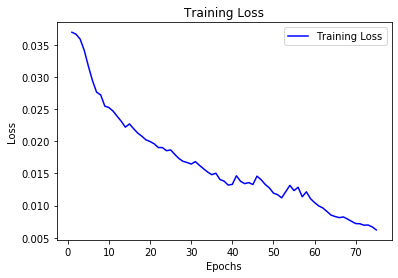

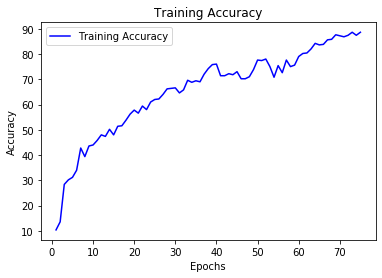

Epoch 1
Loss: 0.024571681022644044 Accuracy: 14.4%
Epoch 2
Loss: 0.024209985733032225 Accuracy: 19.6%
Epoch 3
Loss: 0.023198341369628905 Accuracy: 27.8%
Epoch 4
Loss: 0.021476876576741535 Accuracy: 28.4%
Epoch 5
Loss: 0.019997889518737794 Accuracy: 32.0%
Epoch 6
Loss: 0.018895336151123047 Accuracy: 35.0%
Epoch 7
Loss: 0.018735333442687987 Accuracy: 33.4%
Epoch 8
Loss: 0.01802123483022054 Accuracy: 36.0%
Epoch 9
Loss: 0.01767526578903198 Accuracy: 38.8%
Epoch 10
Loss: 0.017423494974772136 Accuracy: 39.4%
Epoch 11
Loss: 0.01670434872309367 Accuracy: 45.4%
Epoch 12
Loss: 0.016204965432484945 Accuracy: 47.0%
Epoch 13
Loss: 0.015730607827504475 Accuracy: 48.4%
Epoch 14
Loss: 0.015067724704742432 Accuracy: 52.0%
Epoch 15
Loss: 0.01556252638498942 Accuracy: 47.2%
Epoch 16
Loss: 0.015216033299763997 Accuracy: 50.6%
Epoch 17
Loss: 0.014747406800587972 Accuracy: 54.4%
Epoch 18
Loss: 0.014261516571044922 Accuracy: 55.2%
Epoch 19
Loss: 0.014395922501881916 Accuracy: 53.8%
Epoch 20
Loss: 0.01419963

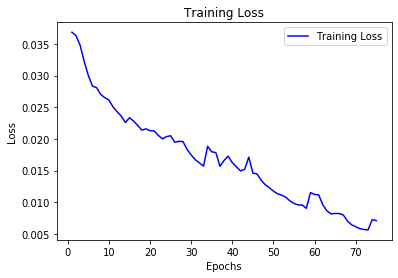

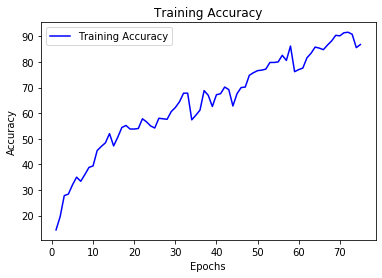

Epoch 1
Loss: 0.024567524592081707 Accuracy: 11.2%
Epoch 2
Loss: 0.024550759315490722 Accuracy: 11.2%
Epoch 3
Loss: 0.02454024378458659 Accuracy: 11.2%
Epoch 4
Loss: 0.02453788725535075 Accuracy: 11.2%
Epoch 5
Loss: 0.024526291529337566 Accuracy: 11.2%
Epoch 6
Loss: 0.024526068369547526 Accuracy: 11.2%
Epoch 7
Loss: 0.024518766085306804 Accuracy: 11.2%
Epoch 8
Loss: 0.024519848505655924 Accuracy: 11.2%
Epoch 9
Loss: 0.024518661816914877 Accuracy: 11.2%
Epoch 10
Loss: 0.024521570205688476 Accuracy: 11.2%
Epoch 11
Loss: 0.024519758224487306 Accuracy: 11.2%
Epoch 12
Loss: 0.024522817293802898 Accuracy: 11.0%
Epoch 13
Loss: 0.02451502323150635 Accuracy: 11.2%
Epoch 14
Loss: 0.024521989504496255 Accuracy: 10.0%
Epoch 15
Loss: 0.02453055508931478 Accuracy: 11.2%
Epoch 16
Loss: 0.024518691698710123 Accuracy: 10.8%
Epoch 17
Loss: 0.024519661903381347 Accuracy: 11.2%
Epoch 18
Loss: 0.024523372968037922 Accuracy: 11.2%
Epoch 19
Loss: 0.024520329475402832 Accuracy: 11.2%
Epoch 20
Loss: 0.02452310

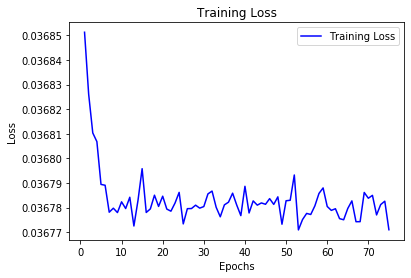

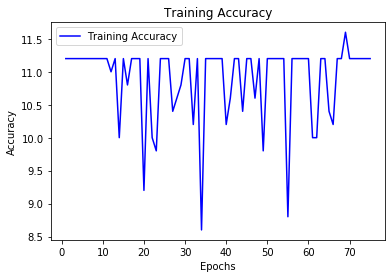

Epoch 1
Loss: 0.024586394945780438 Accuracy: 10.4%
Epoch 2
Loss: 0.02432617155710856 Accuracy: 13.6%
Epoch 3
Loss: 0.02359844366709391 Accuracy: 25.4%
Epoch 4
Loss: 0.022073259194691976 Accuracy: 29.6%
Epoch 5
Loss: 0.020576692263285318 Accuracy: 31.4%
Epoch 6
Loss: 0.01923132673899333 Accuracy: 33.8%
Epoch 7
Loss: 0.018284424781799317 Accuracy: 40.2%
Epoch 8
Loss: 0.01773569393157959 Accuracy: 40.2%
Epoch 9
Loss: 0.017003411610921223 Accuracy: 43.4%
Epoch 10
Loss: 0.016547840277353922 Accuracy: 45.2%
Epoch 11
Loss: 0.016135079542795815 Accuracy: 49.8%
Epoch 12
Loss: 0.015696346759796143 Accuracy: 49.4%
Epoch 13
Loss: 0.015702643712361655 Accuracy: 49.4%
Epoch 14
Loss: 0.015102012793223063 Accuracy: 50.0%
Epoch 15
Loss: 0.014737255414326985 Accuracy: 51.6%
Epoch 16
Loss: 0.014748132228851319 Accuracy: 51.2%
Epoch 17
Loss: 0.014294307390848795 Accuracy: 51.6%
Epoch 18
Loss: 0.013586975733439128 Accuracy: 57.4%
Epoch 19
Loss: 0.013125335693359375 Accuracy: 58.2%
Epoch 20
Loss: 0.01346136

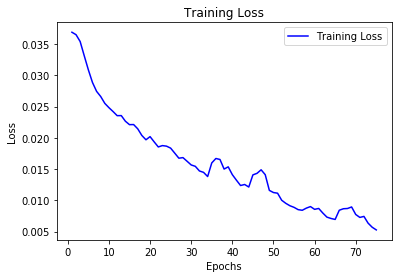

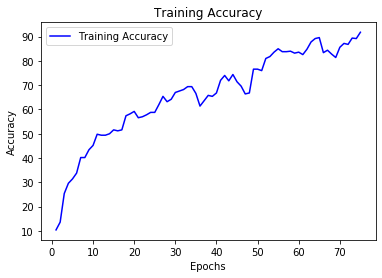

Epoch 1
Loss: 0.04891633605957031 Accuracy: 12.8%
Epoch 2
Loss: 0.046143674532572426 Accuracy: 28.7%
Epoch 3
Loss: 0.04093787813186645 Accuracy: 30.8%
Epoch 4
Loss: 0.03849995883305868 Accuracy: 34.8%
Epoch 5
Loss: 0.036300411542256675 Accuracy: 40.9%
Epoch 6
Loss: 0.035975686073303224 Accuracy: 39.4%
Epoch 7
Loss: 0.034812501430511476 Accuracy: 39.7%
Epoch 8
Loss: 0.03590721813837687 Accuracy: 39.6%
Epoch 9
Loss: 0.03430653047561646 Accuracy: 42.4%
Epoch 10
Loss: 0.032679205576578774 Accuracy: 44.5%
Epoch 11
Loss: 0.03197595469156901 Accuracy: 47.6%
Epoch 12
Loss: 0.031101006507873535 Accuracy: 49.9%
Epoch 13
Loss: 0.030698654333750408 Accuracy: 49.2%
Epoch 14
Loss: 0.03157981252670288 Accuracy: 47.4%
Epoch 15
Loss: 0.03307259432474772 Accuracy: 44.8%
Epoch 16
Loss: 0.031703431765238446 Accuracy: 47.2%
Epoch 17
Loss: 0.029915032863616943 Accuracy: 49.5%
Epoch 18
Loss: 0.030730779965718588 Accuracy: 49.9%
Epoch 19
Loss: 0.031158279259999592 Accuracy: 45.8%
Epoch 20
Loss: 0.031066448052

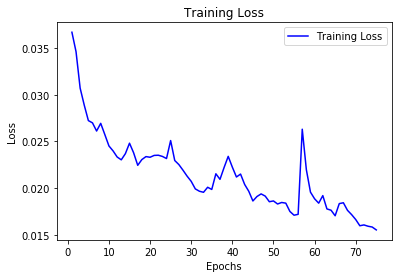

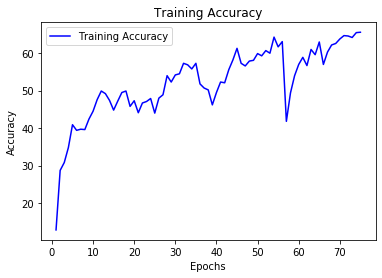

Epoch 1
Loss: 0.04921089045206706 Accuracy: 9.2%
Epoch 2
Loss: 0.049135999043782554 Accuracy: 9.1%
Epoch 3
Loss: 0.04911708386739095 Accuracy: 9.7%
Epoch 4
Loss: 0.049114957809448245 Accuracy: 11.0%
Epoch 5
Loss: 0.049098971048990886 Accuracy: 11.0%
Epoch 6
Loss: 0.049101545651753745 Accuracy: 11.0%
Epoch 7
Loss: 0.049106424967447916 Accuracy: 11.0%
Epoch 8
Loss: 0.049102695465087894 Accuracy: 11.0%
Epoch 9
Loss: 0.049102946917215985 Accuracy: 11.0%
Epoch 10
Loss: 0.04910608355204264 Accuracy: 11.0%
Epoch 11
Loss: 0.04909476470947265 Accuracy: 11.0%
Epoch 12
Loss: 0.04910424137115479 Accuracy: 11.0%
Epoch 13
Loss: 0.049109606742858886 Accuracy: 11.0%
Epoch 14
Loss: 0.04909975242614746 Accuracy: 11.0%
Epoch 15
Loss: 0.04910601425170898 Accuracy: 11.0%
Epoch 16
Loss: 0.049101422309875485 Accuracy: 11.0%
Epoch 17
Loss: 0.049098209698994956 Accuracy: 11.0%
Epoch 18
Loss: 0.04909931723276774 Accuracy: 10.3%
Epoch 19
Loss: 0.049098140080769855 Accuracy: 11.3%
Epoch 20
Loss: 0.049096846262613

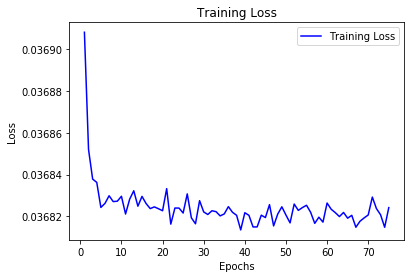

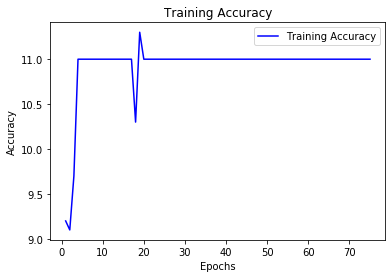

Epoch 1
Loss: 0.024582099278767904 Accuracy: 12.2%
Epoch 2
Loss: 0.02432331148783366 Accuracy: 14.6%
Epoch 3
Loss: 0.02361616039276123 Accuracy: 25.0%
Epoch 4
Loss: 0.022208298524220786 Accuracy: 31.4%
Epoch 5
Loss: 0.020680221875508626 Accuracy: 34.0%
Epoch 6
Loss: 0.019623327096303305 Accuracy: 36.2%
Epoch 7
Loss: 0.018861820062001548 Accuracy: 37.8%
Epoch 8
Loss: 0.018169798215230307 Accuracy: 40.6%
Epoch 9
Loss: 0.01762077045440674 Accuracy: 40.2%
Epoch 10
Loss: 0.017142493565877277 Accuracy: 43.8%
Epoch 11
Loss: 0.016585423310597737 Accuracy: 44.0%
Epoch 12
Loss: 0.01638295888900757 Accuracy: 43.6%
Epoch 13
Loss: 0.01623234717051188 Accuracy: 47.0%
Epoch 14
Loss: 0.015393004894256592 Accuracy: 49.6%
Epoch 15
Loss: 0.015093988100687662 Accuracy: 50.0%
Epoch 16
Loss: 0.014850958983103435 Accuracy: 51.6%
Epoch 17
Loss: 0.014932075023651122 Accuracy: 51.4%
Epoch 18
Loss: 0.015845848083496095 Accuracy: 46.2%
Epoch 19
Loss: 0.01687424373626709 Accuracy: 44.4%
Epoch 20
Loss: 0.0156572092

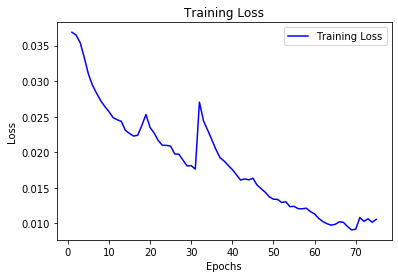

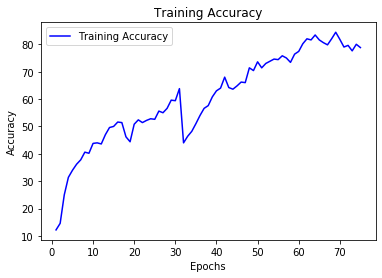

Epoch 1
Loss: 0.11583961470921834 Accuracy: 22.24%
Epoch 2
Loss: 0.0952937881151835 Accuracy: 36.4%
Epoch 3
Loss: 0.09290906763076782 Accuracy: 36.96%
Epoch 4
Loss: 0.08753034941355388 Accuracy: 40.6%
Epoch 5
Loss: 0.08691438372929891 Accuracy: 41.48%
Epoch 6
Loss: 0.08248932218551636 Accuracy: 44.36%
Epoch 7
Loss: 0.07998234685262044 Accuracy: 46.84%
Epoch 8
Loss: 0.0783447863260905 Accuracy: 46.8%
Epoch 9
Loss: 0.07819270896911622 Accuracy: 46.84%
Epoch 10
Loss: 0.07431528329849243 Accuracy: 51.04%
Epoch 11
Loss: 0.07353571224212646 Accuracy: 51.52%
Epoch 12
Loss: 0.07549673732121785 Accuracy: 48.68%
Epoch 13
Loss: 0.0826687331199646 Accuracy: 42.0%
Epoch 14
Loss: 0.08042825412750244 Accuracy: 44.44%
Epoch 15
Loss: 0.0758703138033549 Accuracy: 47.56%
Epoch 16
Loss: 0.07306006860733032 Accuracy: 50.28%
Epoch 17
Loss: 0.07252395137151083 Accuracy: 53.16%
Epoch 18
Loss: 0.06950686772664388 Accuracy: 53.72%
Epoch 19
Loss: 0.06776005713144938 Accuracy: 53.24%
Epoch 20
Loss: 0.067241539796

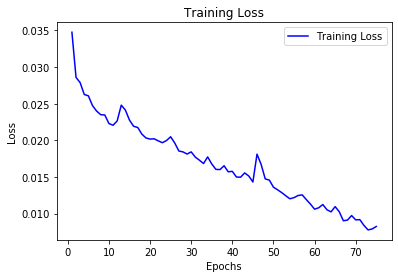

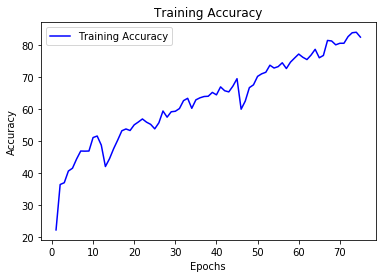

Epoch 1
Loss: 0.12271932633717855 Accuracy: 11.36%
Epoch 2
Loss: 0.12275601069132487 Accuracy: 10.76%
Epoch 3
Loss: 0.12256275844573974 Accuracy: 10.88%
Epoch 4
Loss: 0.1225902951558431 Accuracy: 11.4%
Epoch 5
Loss: 0.12262663237253825 Accuracy: 11.4%
Epoch 6
Loss: 0.12267009576161703 Accuracy: 10.16%
Epoch 7
Loss: 0.12249314467112224 Accuracy: 11.4%
Epoch 8
Loss: 0.12264443588256836 Accuracy: 11.4%
Epoch 9
Loss: 0.12256898180643717 Accuracy: 11.4%
Epoch 10
Loss: 0.12260940011342367 Accuracy: 11.4%
Epoch 11
Loss: 0.12251489194234212 Accuracy: 10.64%
Epoch 12
Loss: 0.12257132657368978 Accuracy: 11.6%
Epoch 13
Loss: 0.12257733980814615 Accuracy: 11.4%
Epoch 14
Loss: 0.12255429172515869 Accuracy: 11.4%
Epoch 15
Loss: 0.12242145570119221 Accuracy: 11.4%
Epoch 16
Loss: 0.12247490851084392 Accuracy: 11.4%
Epoch 17
Loss: 0.12262754185994466 Accuracy: 11.4%
Epoch 18
Loss: 0.12271676858266195 Accuracy: 11.4%
Epoch 19
Loss: 0.12269754409790039 Accuracy: 11.4%
Epoch 20
Loss: 0.12259929847717285 A

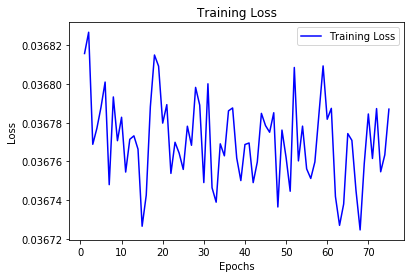

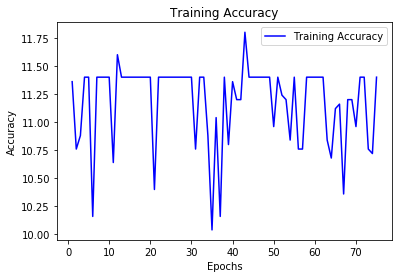

Epoch 1
Loss: 0.02454863166809082 Accuracy: 11.2%
Epoch 2
Loss: 0.024200931866963704 Accuracy: 24.2%
Epoch 3
Loss: 0.023163968086242676 Accuracy: 30.8%
Epoch 4
Loss: 0.021464845657348634 Accuracy: 33.6%
Epoch 5
Loss: 0.020061801592508952 Accuracy: 36.6%
Epoch 6
Loss: 0.019107123533884683 Accuracy: 36.2%
Epoch 7
Loss: 0.01848885711034139 Accuracy: 38.4%
Epoch 8
Loss: 0.017655752023061116 Accuracy: 39.6%
Epoch 9
Loss: 0.016990128993988038 Accuracy: 43.6%
Epoch 10
Loss: 0.01662588405609131 Accuracy: 44.0%
Epoch 11
Loss: 0.016639808495839438 Accuracy: 46.0%
Epoch 12
Loss: 0.015710766792297364 Accuracy: 46.4%
Epoch 13
Loss: 0.015225962956746419 Accuracy: 49.4%
Epoch 14
Loss: 0.015035959084828694 Accuracy: 52.8%
Epoch 15
Loss: 0.015271112600962321 Accuracy: 47.0%
Epoch 16
Loss: 0.016638759771982828 Accuracy: 46.8%
Epoch 17
Loss: 0.015462607383728027 Accuracy: 50.2%
Epoch 18
Loss: 0.014579654375712077 Accuracy: 51.4%
Epoch 19
Loss: 0.01488664166132609 Accuracy: 49.2%
Epoch 20
Loss: 0.01444127

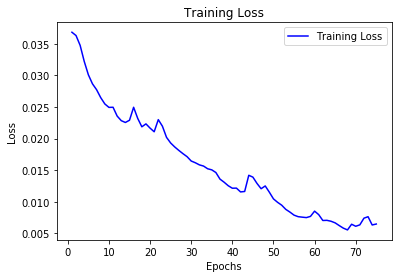

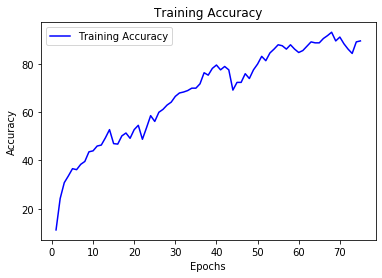

Epoch 1
Loss: 0.553353362719218 Accuracy: 35.93333333333333%
Epoch 2
Loss: 0.4492550005912781 Accuracy: 48.52%
Epoch 3
Loss: 0.3959264648755391 Accuracy: 54.75333333333333%
Epoch 4
Loss: 0.35913664054870603 Accuracy: 59.3%
Epoch 5
Loss: 0.32837729303042096 Accuracy: 62.64%
Epoch 6
Loss: 0.3004347674846649 Accuracy: 65.87333333333333%
Epoch 7
Loss: 0.27978191018104553 Accuracy: 68.69333333333333%
Epoch 8
Loss: 0.2571863475640615 Accuracy: 70.94666666666667%
Epoch 9
Loss: 0.23854996156692504 Accuracy: 73.29333333333334%
Epoch 10
Loss: 0.22069590524832408 Accuracy: 75.06%
Epoch 11
Loss: 0.207845756093661 Accuracy: 77.02666666666667%
Epoch 12
Loss: 0.19494725080331166 Accuracy: 78.34666666666666%
Epoch 13
Loss: 0.17805907758076986 Accuracy: 80.1%
Epoch 14
Loss: 0.16597635384400686 Accuracy: 81.64%
Epoch 15
Loss: 0.15410465077559155 Accuracy: 83.28%
Epoch 16
Loss: 0.14552024215459824 Accuracy: 84.26666666666667%
Epoch 17
Loss: 0.1334462093313535 Accuracy: 85.66666666666667%
Epoch 18
Loss: 0

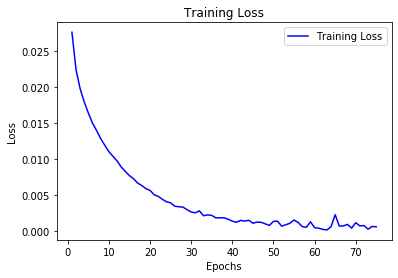

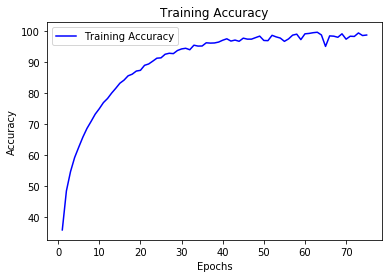

In [250]:
FC_RNN_PARAMS_1 = {
    'audio_in_features' : 25, # static
    'fc_1_out' : 320, # new
    'fc_2_out' : 160, # new
    'fc_3_out' : 80, # new, used to be fc_3_out = rnn_in_size = 24
    'fc_4_out' : 40, # new
    'rnn_in_size' : 24, # probably okay but will investigate
    'rnn_hid_size' : 48, # probably okay 
    'rnn_dropout' : 0.5, # okay
    'epochs' : 75, # ONLY FOR BUG TESTING
    'lr' : 0.001, # seems like it works well enough
    'weight_decay': 0, # seems to not really have an affect
    'deep' : False,
    
    'silence' : False
    # using 1 bnorm layer
}

dls = [dl_1, dl_2, dl_5, dl_30]

analyze_all_data_augmentations(dls)

In [252]:
# generating flipped things

def analyze_data_augmentation_vanillas(dl):
    X_train, Y_train, X_val, X_test = make_vanilla(dl)
    
    names_vanilla_cr = {
        'val_predictions' : 'val_predictions_vanilla_cr',
        'test_predictions' : 'test_predictions_vanilla_cr',
        'model' : 'model_vanilla_cr'
    }
    
    names_vanilla_sfr = {
        'val_predictions' : 'val_predictions_vanilla_sfr',
        'test_predictions' : 'test_predictions_vanilla_sfr',
        'model' : 'model_vanilla_sfr'
    }
    
    names_vanilla_dfr = {
        'val_predictions' : 'val_predictions_vanilla_dfr',
        'test_predictions' : 'test_predictions_vanilla_dfr',
        'model' : 'model_vanilla_dfr'
    }

    nn_analysis(X_train, Y_train, X_val, X_test, 'cnn_rnn', names_vanilla_cr)
        
    nn_analysis(X_train, Y_train, X_val, X_test, 'shallow_fc_rnn', names_vanilla_sfr)
        
    nn_analysis(X_train, Y_train, X_val, X_test, 'deep_fc_rnn', names_vanilla_dfr)

Epoch 1
Loss: 0.023857568422953286 Accuracy: 15.6%
Epoch 2
Loss: 0.021621214230855307 Accuracy: 28.2%
Epoch 3
Loss: 0.01986692460378011 Accuracy: 31.2%
Epoch 4
Loss: 0.020445771058400473 Accuracy: 29.6%
Epoch 5
Loss: 0.019649194399515787 Accuracy: 31.4%
Epoch 6
Loss: 0.018478121121724447 Accuracy: 36.6%
Epoch 7
Loss: 0.017363149007161457 Accuracy: 39.0%
Epoch 8
Loss: 0.01763694429397583 Accuracy: 38.8%
Epoch 9
Loss: 0.01770242961247762 Accuracy: 37.6%
Epoch 10
Loss: 0.016402700424194335 Accuracy: 45.0%
Epoch 11
Loss: 0.016170257250467935 Accuracy: 42.8%
Epoch 12
Loss: 0.018059168815612793 Accuracy: 38.8%
Epoch 13
Loss: 0.017058419863382975 Accuracy: 40.4%
Epoch 14
Loss: 0.016371845881144206 Accuracy: 43.2%
Epoch 15
Loss: 0.016124138673146566 Accuracy: 47.2%
Epoch 16
Loss: 0.015726264158884683 Accuracy: 45.0%
Epoch 17
Loss: 0.01563857158025106 Accuracy: 45.4%
Epoch 18
Loss: 0.014981732686360678 Accuracy: 48.2%
Epoch 19
Loss: 0.014941069602966308 Accuracy: 49.4%
Epoch 20
Loss: 0.01459094

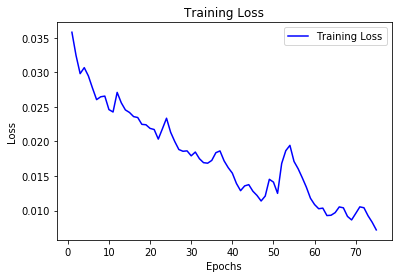

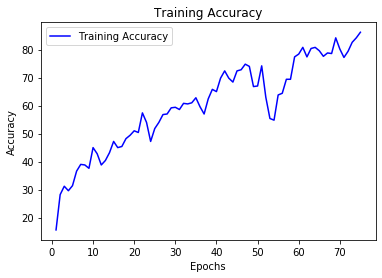

Epoch 1
Loss: 0.02450733439127604 Accuracy: 13.4%
Epoch 2
Loss: 0.024050859451293944 Accuracy: 22.0%
Epoch 3
Loss: 0.02285506852467855 Accuracy: 27.0%
Epoch 4
Loss: 0.021249223391215006 Accuracy: 29.6%
Epoch 5
Loss: 0.019935758113861085 Accuracy: 31.6%
Epoch 6
Loss: 0.01887337334950765 Accuracy: 35.6%
Epoch 7
Loss: 0.018049408753712973 Accuracy: 41.0%
Epoch 8
Loss: 0.01743030055363973 Accuracy: 42.2%
Epoch 9
Loss: 0.01685412406921387 Accuracy: 45.4%
Epoch 10
Loss: 0.016136648178100586 Accuracy: 46.0%
Epoch 11
Loss: 0.016651128451029458 Accuracy: 42.8%
Epoch 12
Loss: 0.01600169054667155 Accuracy: 47.2%
Epoch 13
Loss: 0.015267138957977294 Accuracy: 50.8%
Epoch 14
Loss: 0.015560673236846925 Accuracy: 49.8%
Epoch 15
Loss: 0.014860611120859782 Accuracy: 52.8%
Epoch 16
Loss: 0.015006798108418783 Accuracy: 51.6%
Epoch 17
Loss: 0.014423302968343099 Accuracy: 52.4%
Epoch 18
Loss: 0.014244838237762451 Accuracy: 53.4%
Epoch 19
Loss: 0.01388835875193278 Accuracy: 55.2%
Epoch 20
Loss: 0.01347798156

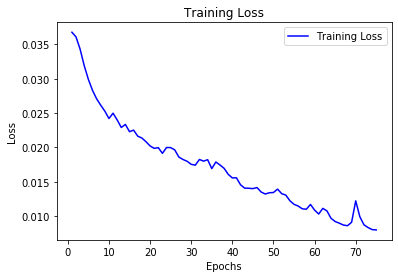

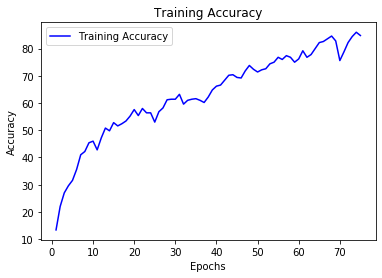

Epoch 1
Loss: 0.024593364079793293 Accuracy: 10.0%
Epoch 2
Loss: 0.024503389994303387 Accuracy: 15.4%
Epoch 3
Loss: 0.024147644678751627 Accuracy: 17.8%
Epoch 4
Loss: 0.02292194906870524 Accuracy: 20.0%
Epoch 5
Loss: 0.021556670665740966 Accuracy: 24.8%
Epoch 6
Loss: 0.020761868953704833 Accuracy: 31.2%
Epoch 7
Loss: 0.01989478079477946 Accuracy: 32.0%
Epoch 8
Loss: 0.019161725680033367 Accuracy: 32.8%
Epoch 9
Loss: 0.01848263390858968 Accuracy: 36.0%
Epoch 10
Loss: 0.017827539761861164 Accuracy: 37.6%
Epoch 11
Loss: 0.0177708683013916 Accuracy: 37.6%
Epoch 12
Loss: 0.018184075196584066 Accuracy: 37.4%
Epoch 13
Loss: 0.01800547933578491 Accuracy: 37.2%
Epoch 14
Loss: 0.017470465660095216 Accuracy: 41.4%
Epoch 15
Loss: 0.017076776027679444 Accuracy: 40.4%
Epoch 16
Loss: 0.01678057018915812 Accuracy: 42.8%
Epoch 17
Loss: 0.016297147432963052 Accuracy: 43.4%
Epoch 18
Loss: 0.016212339719136555 Accuracy: 45.4%
Epoch 19
Loss: 0.01616776752471924 Accuracy: 43.6%
Epoch 20
Loss: 0.016859899202

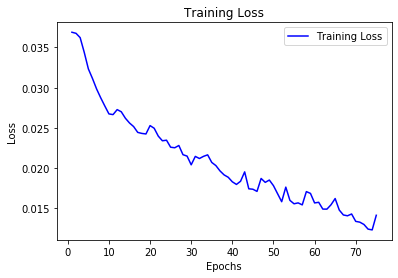

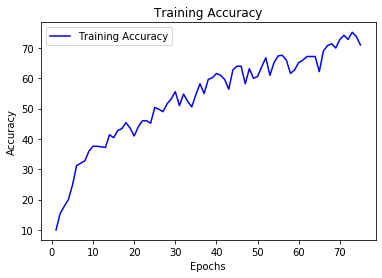

In [253]:
analyze_data_augmentation_vanillas(dl_1)

In [ ]:
def analyze_data_augmentation_vanillas_flipped(dl):
    X_train, Y_train, X_val, X_test = make_vanilla(dl)
    
    X_train = np.flip(X_train, axis=2).copy()
    
    names_vanilla_cr = {
        'val_predictions' : 'val_predictions_vanilla_flipped_cr',
        'test_predictions' : 'test_predictions_vanilla_flipped_cr',
        'model' : 'model_vanilla_flipped_cr'
    }
    
    names_vanilla_sfr = {
        'val_predictions' : 'val_predictions_vanilla_flipped_sfr',
        'test_predictions' : 'test_predictions_vanilla_flipped_sfr',
        'model' : 'model_vanilla_flipped_sfr'
    }
    
    names_vanilla_dfr = {
        'val_predictions' : 'val_predictions_vanilla_flipped_dfr',
        'test_predictions' : 'test_predictions_vanilla_flipped_dfr',
        'model' : 'model_vanilla_flipped_dfr'
    }

    nn_analysis(X_train, Y_train, X_val, X_test, 'cnn_rnn', names_vanilla_cr)
    nn_analysis(X_train, Y_train, X_val, X_test, 'shallow_fc_rnn', names_vanilla_sfr)
    nn_analysis(X_train, Y_train, X_val, X_test, 'deep_fc_rnn', names_vanilla_dfr)

In [ ]:
analyze_data_augmentation_vanillas_flipped(dl_1)

(500, 25, 1290)
(500, 25, 1290)
Epoch 1
Loss: 0.024398218790690103 Accuracy: 12.8%
Epoch 2
Loss: 0.021935631116231282 Accuracy: 23.6%
Epoch 3
Loss: 0.02029301150639852 Accuracy: 30.0%
Epoch 4
Loss: 0.01946392567952474 Accuracy: 29.6%
Epoch 5
Loss: 0.01885598119099935 Accuracy: 34.4%
Epoch 6
Loss: 0.018720836798350016 Accuracy: 33.8%
Epoch 7
Loss: 0.01778934399286906 Accuracy: 36.2%
Epoch 8
Loss: 0.017646746953328452 Accuracy: 37.4%
Epoch 9
Loss: 0.01705730851491292 Accuracy: 40.4%
Epoch 10
Loss: 0.01672459014256795 Accuracy: 39.6%
Epoch 11


TODO:
- try different datapreprocessing: change # of channels for 1d stuff so that we get slices through all the different features of the MFCC 
- rewrite code for DCNN generation to support more versitile dimensionalities
- make RNN: LSTM + (D)CNN
- uncomment out bnorm in CNN generation code

Function:
- Input x_train, x_val, x_test, y_train
- Output model.predict(x_val), model.predict(x_test)
- save model and outputs

# OLD

## CNN

In [ ]:
# class Conv_Block(nn.Module):
    
#     def __init__(self, in_planes, planes, kernel_size, stride, pool_size):
        
#         super(Conv_Block, self).__init__()
        
#         self.conv = nn.Conv1d(in_channels = in_planes, out_channels = planes, kernel_size = kernel_size, stride=stride)
#         self.dropout = nn.Dropout(p=0.5)
#         self.maxpool = nn.AvgPool1d(kernel_size = pool_size)
#         self.bnorm = nn.BatchNorm1d(num_features = planes)
    
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.dropout(x)
#         x = self.maxpool(x)
#         x = self.bnorm(x)
#         x = F.relu(x)
        
#         return x

# class Conv(nn.Module):
    
#     def __init__(self, params):    
#         super(Conv, self).__init__()
        
#         filters = params['filters']
#         kernel_sizes = params['kernel_sizes']
#         strides = params['strides']
#         avg_pool_sizes = params['max_pool_sizes']
        
#         assert(len(filters) == len(kernel_sizes))
#         assert(len(filters) == len(strides))
#         assert(len(filters) == len(avg_pool_sizes))
        
#         prev_outplanes = 1
#         prev_outsize = params['input_length']
        
#         layers = []
        
#         for i in range(len(filters)):
#             inplanes = prev_outplanes
#             outplanes = inplanes * filters[i]
#             out_size = math.floor((math.floor((prev_outsize - kernel_sizes[i]) / float(strides[i]))+\
#                                 1)/float(avg_pool_sizes[i]))
            
#             prev_outsize = out_size
#             prev_outplanes = outplanes
            
#             new_block = Conv_Block(inplanes, outplanes, kernel_sizes[i], strides[i], avg_pool_sizes[i])
            
#             layers.append(new_block)
            
#         self.convs = nn.Sequential(*layers)
        
#         in_features = prev_outsize * prev_outplanes
        
#         self.fc = nn.Linear(in_features = in_features, out_features = 10)
        
#     def forward(self, x):
#         x = self.convs(x)
#         x = x.view(x.size()[0], -1)
#         x = self.fc(x)
#         return x

In [ ]:
# Debugging

# big big convnet
# conv_params = {
#     'input_length' : 16770,
#     'filters' : [8, 8, 8, 8],
#     'kernel_sizes' : [64, 32, 16, 8],
#     'strides' : [8, 4, 2, 1],
#     'max_pool_sizes' : [2, 2, 2, 2]
# }

# smaller convnet
# conv_params = {
#     'input_length' : 16770,
#     'filters' : [8, 16, 64],
#     'kernel_sizes' : [64, 8, 4],
#     'strides' : [8, 4, 2],
#     'max_pool_sizes' : [16, 4, 2]
# }

# smallest convnet
conv_params = {
    'input_length' : 16770,
    'filters' : [8, 64],
    'kernel_sizes' : [64, 4],
    'strides' : [8, 2],
    'max_pool_sizes' : [32, 4]
}

# observation: this net works as long as we don't run out of elements to convolute across (no padding)

conv_test = Conv(conv_params)
# clipper = WeightClipper()
# conv_test.apply(clipper)
summary(conv_test, (1,16770))

## DCNN

In [195]:
class DConv_Block(nn.Module):
    
    def __init__(self, in_planes, planes, kernel_size, dialation, pool_size):
        
        super(DConv_Block, self).__init__()
        
        padding = int((kernel_size + (kernel_size - 1)*(dialation - 1) - 1)/2)
        
        self.dconv = nn.Conv1d(in_channels = in_planes, out_channels = planes,
                               kernel_size = kernel_size, stride=1, padding=padding, dilation=dialation)
        self.dropout = nn.Dropout(p=0.5)
        self.avgpool = nn.AvgPool1d(kernel_size = pool_size)
        self.bnorm = nn.BatchNorm1d(num_features = planes)
    
    def forward(self, x):
        x = self.dconv(x)
        x = self.dropout(x)
        x = self.avgpool(x)
        x = self.bnorm(x)
        x = F.relu(x)
        return x

class DConv(nn.Module):
    
    def __init__(self, params):    
        super(DConv, self).__init__()
        
        filters = params['filters']
        kernel_sizes = params['kernel_sizes']
        dialations = params['dialations']
        avg_pool_sizes = params['avg_pool_sizes']
        
        assert(len(filters) == len(kernel_sizes))
        assert(len(filters) == len(dialations))
        assert(len(filters) == len(avg_pool_sizes))
        
        prev_outplanes = 1
        prev_outsize = params['input_length']

        layers = []
        
        for i in range(len(filters)):
            inplanes = prev_outplanes
            outplanes = inplanes * filters[i]
            
            out_size = math.floor(prev_outsize / float(avg_pool_sizes[i]))
            
            prev_outsize = out_size
            prev_outplanes = outplanes
            
            new_block = DConv_Block(inplanes, outplanes, kernel_sizes[i], dialations[i], avg_pool_sizes[i])
            
            layers.append(new_block)
            
        self.dconvs = nn.Sequential(*layers)
        
        in_features = prev_outsize * prev_outplanes
        
        self.fc = nn.Linear(in_features = in_features, out_features = 10)
        
    def forward(self, x):
        x = self.dconvs(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x


In [196]:
# Debugging
dconv_params = {
    'input_length' : 16770,
    'filters' : [16, 4],
    'kernel_sizes': [64, 16],
    'dialations': [8, 2],
    'avg_pool_sizes': [32, 4]
}

# observation: this net works as long as dialation_2 is even

dconv_test = DConv(dconv_params)
summary(dconv_test, (1,16770))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 16770]           1,040
           Dropout-2            [-1, 16, 16770]               0
         AvgPool1d-3              [-1, 16, 524]               0
       BatchNorm1d-4              [-1, 16, 524]              32
       DConv_Block-5              [-1, 16, 524]               0
            Conv1d-6              [-1, 64, 524]          16,448
           Dropout-7              [-1, 64, 524]               0
         AvgPool1d-8              [-1, 64, 131]               0
       BatchNorm1d-9              [-1, 64, 131]             128
      DConv_Block-10              [-1, 64, 131]               0
           Linear-11                   [-1, 10]          83,850
Total params: 101,498
Trainable params: 101,498
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/

# Evaluating Models

In [197]:
# from brendan
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(test_labels, predictions, title):
    ax= plt.subplot()
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, ax = ax, cmap = sns.cm.rocket_r); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'{title} Confusion Matrix'); 
    ax.set_ylim(top=0, bottom=10)
    ax.xaxis.set_ticklabels(all_genres); ax.yaxis.set_ticklabels(all_genres);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.show()

In [198]:
# test_labels = Y_test

def net_confusion_matrix(net, testloader, test_labels, title):
    
    separate_predictions = []
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    net.eval()
    
    with torch.no_grad():
        for data in testloader:
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            separate_predictions.append(predicted.numpy())
    
    predictions = np.concatenate(separate_predictions)
    plot_confusion_matrix(test_labels, predictions, title)            

In [199]:
conv_net = Conv(conv_params)

# regularizing
conv_net.apply(clipper)

conv_crit = nn.CrossEntropyLoss()
conv_opt = torch.optim.Adam(conv_net.parameters(), lr=0.001)

NameError: name 'Conv' is not defined

In [201]:
dconv_net = DConv(dconv_params)

# regularizing
clipper = WeightClipper()
dconv_net.apply(clipper)

dconv_crit = nn.CrossEntropyLoss()
dconv_opt = torch.optim.Adam(dconv_net.parameters(), lr=0.001)

In [ ]:
# %%time
# # training and evaluating CNN

# train(conv_net, conv_crit, conv_opt, 30, genre_trainloader)
# test(conv_net, genre_testloader)
# net_confusion_matrix(conv_net, genre_testloader, Y_test, "Preliminary CNN")

In [202]:
# %%time
# # training and evaluating DCNN

train(dconv_net, dconv_crit, dconv_opt, 30, genre_trainloader)
test(dconv_net, genre_testloader)
net_confusion_matrix(dconv_net, genre_testloader, Y_test, "Preliminary DCNN")

NameError: name 'genre_trainloader' is not defined